# LDA topic modeling

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# settings
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]
BAG = CHAP

# import tables
output_dir = "/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output"
TOKENS = pd.read_csv(f'{output_dir}/CORPUS.csv').set_index(OHCO)
LIB = pd.read_csv(f"{output_dir}/lib.csv").set_index('book_id')

In [2]:
# create DOCS, filter for nouns and verbs only
DOCS = TOKENS[TOKENS.pos.str.match(r'^(NN|NNS|VB|VBD|VBG|VBN|VBP|VBZ|JJ|JJR|JJS)$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(map(str, x)))\
    .to_frame()\
    .rename(columns={'term_str': 'doc_str'})

DOCS

doc_str
book_id         chap_id                                                   
BetweenTheActs  1        was summers night were talking big room window...
                2        nurses breakfast were trundling perambulator t...
                3        drew comb thick tangle hair which giving matte...
                4        foolish flattering lady pausing threshold call...
                5        had nailed placard was great building farmyard...
...                                                                    ...
ToTheLighthouse 39       the sea stain it thought standing looking bay ...
                40       was then island thought drawing fingers waves ...
                41       much depends then thought looking sea had stai...
                42       had done reading hand hovered page be readines...
                43       he have reached it said feeling tired out had ...

[209 rows x 1 columns]

In [3]:
# create vector space using SciKitLearn's CountVectorizer
count_engine = CountVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [4]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

VOCAB

,doc_count
term_str,
aback,6
abandonment,13
able,62
able say,6
abroad,6
...,...
youth,46
youthful,6
youve,46


In [5]:
DOCS.term_count.describe()

count      209.000000
mean      1519.220096
std       1880.481216
min          3.000000
25%        421.000000
50%       1114.000000
75%       1955.000000
max      16563.000000
Name: term_count, dtype: float64

## Generate model

In [6]:
# specify model
n_topics=40
lda_engine = LDA(n_components=n_topics, max_iter=20, learning_offset=50., random_state=0)
lda_model = lda_engine.fit_transform(count_model)

# topic names
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

## Creating TOPICS, PHI, and THETA tables

In [7]:
# theta
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

THETA.sample(10)

T00       T01       T02       T03       T04  \
book_id        chap_id                                                     
BetweenTheActs 5        0.000117  0.000117  0.000117  0.000117  0.000117   
Orlando        6        0.000004  0.000004  0.000004  0.000004  0.000004   
NightAndDay    14       0.028393  0.000016  0.000016  0.000016  0.000016   
Orlando        4        0.000004  0.000004  0.000004  0.000004  0.000004   
TheVoyageOut   13       0.000029  0.000029  0.000029  0.000029  0.000029   
               22       0.000013  0.000013  0.000013  0.000013  0.000013   
BetweenTheActs 11       0.000051  0.000051  0.000051  0.000051  0.000051   
               32       0.000198  0.000198  0.000198  0.000198  0.000198   
Orlando        1        0.000006  0.000006  0.000006  0.000006  0.000006   
TheWaves       21       0.000108  0.000108  0.000108  0.000108  0.000108   

                             T05       T06       T07       T08       T09  ...  \
book_id        chap_id                                                    ...   
BetweenTheActs 5        0.000117  0.000117  0.000117  0.000117  0.000117  ...   
Orlando        6        0.000004  0.000004  0.000004  0.000004  0.000004  ...   
NightAndDay    14       0.000016  0.000016  0.000016  0.000016  0.000016  ...   
Orlando        4        0.000004  0.000004  0.000004  0.000004  0.000004  ...   
TheVoyageOut   13       0.000029  0.000029  0.000029  0.000029  0.000029  ...   
               22       0.000013  0.000013  0.000013  0.000013  0.000013  ...   
BetweenTheActs 11       0.000051  0.000051  0.000051  0.998030  0.000051  ...   
               32       0.000198  0.000198  0.000198  0.000198  0.000198  ...   
Orlando        1        0.000006  0.000006  0.000006  0.000006  0.000006  ...   
TheWaves       21       0.000108  0.000108  0.000108  0.000108  0.225963  ...   

                             T30       T31       T32       T33       T34  \
book_id        chap_id                                                     
BetweenTheActs 5        0.000117  0.000117  0.000117  0.000117  0.000117   
Orlando        6        0.000004  0.000004  0.000004  0.000004  0.000004   
NightAndDay    14       0.000016  0.000016  0.000016  0.000016  0.000016   
Orlando        4        0.000004  0.000004  0.000004  0.000004  0.000004   
TheVoyageOut   13       0.000029  0.000029  0.000029  0.000029  0.000029   
               22       0.000013  0.000013  0.000013  0.000013  0.000013   
BetweenTheActs 11       0.000051  0.000051  0.000051  0.000051  0.000051   
               32       0.000198  0.000198  0.000198  0.000198  0.000198   
Orlando        1        0.000006  0.000006  0.000006  0.000006  0.000006   
TheWaves       21       0.000108  0.000108  0.000108  0.000108  0.000108   

                             T35       T36       T37       T38       T39  
book_id        chap_id                                                    
BetweenTheActs 5        0.000117  0.000117  0.000117  0.995444  0.000117  
Orlando        6        0.000004  0.000004  0.000004  0.000004  0.000004  
NightAndDay    14       0.000016  0.000016  0.000016  0.000016  0.000016  
Orlando        4        0.000004  0.000004  0.000004  0.000004  0.000004  
TheVoyageOut   13       0.000029  0.000029  0.000029  0.000029  0.000029  
               22       0.000013  0.000013  0.000013  0.000013  0.000013  
BetweenTheActs 11       0.000051  0.000051  0.000051  0.000051  0.000051  
               32       0.000198  0.000198  0.000198  0.000198  0.000198  
Orlando        1        0.000006  0.000006  0.000006  0.000006  0.000006  
TheWaves       21       0.000108  0.000108  0.000108  0.000108  0.000108  

[10 rows x 40 columns]

In [8]:
# phi
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

PHI.T.sample(10)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,...,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,
lend,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
said wished,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
sale,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
wanted talk,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
enlarged,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
hand eyes,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
edward,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
swelled,0.025,0.025,0.025,0.025,1.025,0.025,0.025,0.025,0.025,0.025,...,1.018482,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
tipped,0.025,0.025,0.025,0.025,1.025,0.025,0.025,0.025,0.025,2.025,...,0.025000,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025


In [9]:
# topics
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(5).reset_index().term_str))\
    .to_frame('top_terms')

TOPICS.head(5)

,top_terms
topic_id,
T00,committee said sparrows came come
T01,aback rapid rang bell range ranged
T02,eyes said face head change
T03,boots things come said table
T04,said trees eyes light sea


In [10]:
# sort by mean document weight
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.sort_values('doc_weight_sum', ascending=False).head(5)

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T26,said thought little looked did,99.410487,0.651429
T20,think dont mind time life,19.568031,0.090572
T21,come let look make moment,10.656986,0.050434
T27,life great say woman come,9.110241,0.048914
T04,said trees eyes light sea,8.530569,0.018425


## LDA + PCA Visualization

Apply PCA to the PHI table and plot the topics in the space opened by the first two components.

Size the points based on the mean document weight of each topic (using the THETA table).

Color the points basd on a metadata feature from the LIB table.

In [19]:
# apply PCA to normalized PHI table
phi_normalized = normalize(PHI, norm='l2', axis=1)
phi_pca = PCA(2).fit_transform(phi_normalized)

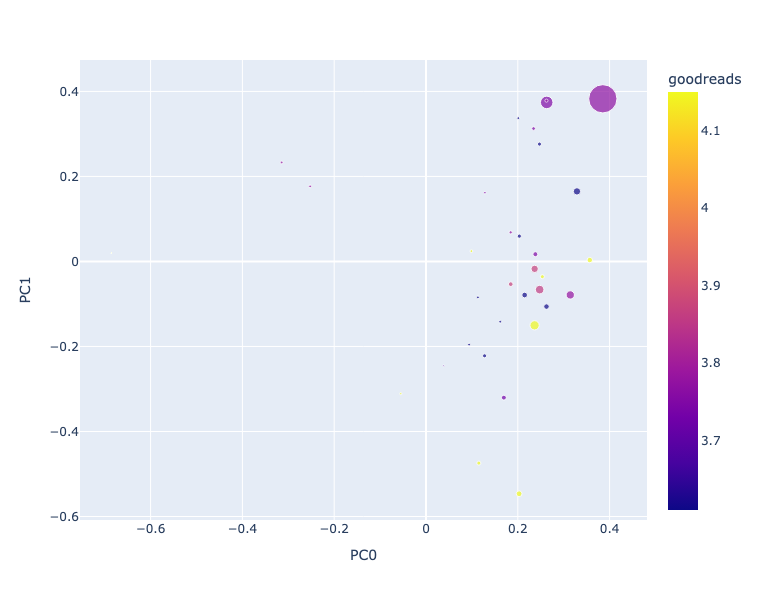

In [31]:
# plot with first two components
pca_plot = pd.DataFrame(phi_pca, index=PHI.index, columns=['PC0', 'PC1'])

# size points based on mean document weight using THETA
pca_plot['mean_doc_weight'] = THETA.mean()

# assign dominant book to each topic
topic_to_book_id = THETA.groupby(BOOK).mean().idxmax()
pca_plot['book_id'] = topic_to_book_id

# join with LIB metadata and TOPIC top terms
pca_plot = pca_plot.join(LIB[['title', 'year', 'goodreads']], on='book_id')
pca_plot = pca_plot.join(TOPICS)

# plot
px.scatter(
    pca_plot.reset_index(), # reset index to make topic_id a column
    x='PC0',
    y='PC1',
    size='mean_doc_weight',
    color='goodreads',
    hover_name='top_terms',
    hover_data=['year', 'goodreads', 'book_id'], 
    height=600,
    width=700
)
